     |████████████████████████████████| 283 kB 403 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


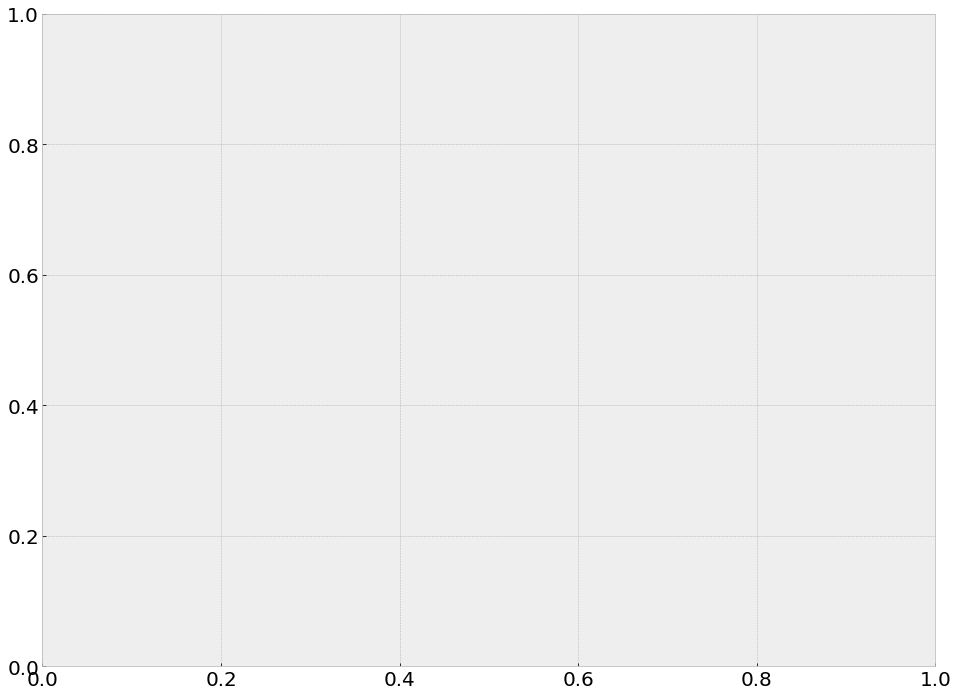

In [1]:
from cwgan_base import *


import math
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from scipy.stats import multivariate_normal, beta

plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
pl.rcParams["figure.figsize"] = (8*2,6*2)
pl.style.use('bmh')
pl.xticks(fontsize=20)
pl.yticks(fontsize = 20)

from itertools import product
from tqdm import tqdm
from sklearn.manifold import TSNE
from time import time
!pip install seaborn --upgrade
import seaborn as sns

starting_time = time()

# Decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [2]:
import pandas
df = pandas.read_csv('../input/meantemp-germancities/export_data_nn_wetter.csv')
print(df)
data = df.to_numpy()[:,2:]

      Unnamed: 0  MESS_DATUM  TMI_1  TMI_2  TMI_3  TMI_5  TMI_7  TMI_8  TMI_9  \
0          48394    20060701   22.2   19.3   19.9   18.4   21.4   19.8   19.0   
1          48395    20060702   23.5   21.6   22.3   19.1   21.5   20.5   20.1   
2          48396    20060703   23.9   21.7   22.8   20.2   22.1   20.7   20.5   
3          48397    20060704   24.9   22.7   23.5   21.7   23.7   22.7   22.8   
4          48398    20060705   26.9   24.8   25.3   23.0   25.8   23.7   24.9   
...          ...         ...    ...    ...    ...    ...    ...    ...    ...   
4774       53168    20190727   23.7   23.4   24.0   23.2   24.0   23.4   23.7   
4775       53169    20190728   25.4   23.6   23.4   21.7   25.1   23.3   22.4   
4776       53170    20190729   25.5   20.7   21.4   22.2   26.3   24.5   19.9   
4777       53171    20190730   22.2   22.7   23.8   21.9   23.8   23.6   22.3   
4778       53172    20190731   20.0   19.9   20.1   18.2   20.7   20.1   20.0   

      TMI_10  ...  TMI_29  

In [3]:
def gen_pred(day, G, num_z = 1000):
    y_base = day.repeat(64, 1).float()
    z = compute_noise(64, z_dim)
    gens = G(z, y_base)

    for _ in range(int(np.ceil(num_z/64 - 1))):
        z = compute_noise(64, z_dim)
        gens = torch.cat((gens, G(z, y_base)), 0)
            
    return gens[:num_z,:]


def gen_ber(G, y_test, num_z = 1000, city_idx = 0):
    num_test = y_test.shape[0]

    #y_base = torch.zeros((64,y.shape[1]))
    gens_ber = np.zeros((num_test, num_z))
    
    #predict next day
    for day_idx in range(num_test):
        day = torch.tensor(y_test[day_idx,:])

        # 1000 gens for next day
        gens = gen_pred(day, G, num_z = num_z)

        #only berlin
        gens_ber[day_idx,:] = gens[:,city_idx].flatten().detach().cpu().numpy()
    return gens_ber

In [4]:
days_back = 1
num_cities = 32
data = data[:,:num_cities]

# x begins at day days_back
x = data[days_back:,:]

# we condition on all measurements of the past view days
y = np.zeros((x.shape[0], x.shape[1], days_back))
for i in range(x.shape[0]):
    for k in range(days_back):
        y[i,:,k] = data[i+days_back-k-1,:]
        

# first 32 entries, day before, then day before that, and so on
y = y.reshape((y.shape[0], -1), order='F')
print(y.shape)
print(x.shape)

(4778, 32)
(4778, 32)


In [5]:
random.seed(1057)
torch.manual_seed(1057)



x_dim = x.shape[1] #32
y_dim = y.shape[1] #32 * 1 day back
test_idx = int(np.ceil((4779-days_back)*0.8999))
num_test = 4779-days_back-test_idx
num_z = 1000

berlin_days = x[test_idx:(test_idx+num_test),0]
x_test = x[test_idx:(test_idx+num_test),:]
y_test = y[test_idx:(test_idx+num_test),:]

x_dim = 1 #32

trains, tests = get_cdataloader(x[:,[0]], y, tt_split = 0.8999, shuffle = False) #only ber [:,[0]]

In [6]:
#network architectures
#gdim=128
#ddim = 256
# input, 3 hidden layers, output layer
#network architectures
gdim=10
ddim = 32
z_dim = 4
pg = (z_dim+y_dim, gdim, gdim, gdim, x_dim)
pd = (x_dim+y_dim, ddim,ddim,ddim,ddim, ddim, 1)

In [7]:
random.seed(1057)
torch.manual_seed(1057)


model = cWGAN(pg, pd)

trainerb = cWGANTrainer(model=model, trains=trains, datas = data, testset=tests, gantype = 'wgangp')

# train D and G with estimates after each epoch, use num_batches for estimates
trainerb.train_estim(num_epochs=150, penalty = 0.1, G_lr=1e-4, D_lr=1e-4, G_wd = 0.01, D_wd = 0.01, D_steps_standard=5, num_batches = 1, num_estims = 10)

100%|██████████| 150/150 [01:20<00:00,  1.86it/s]


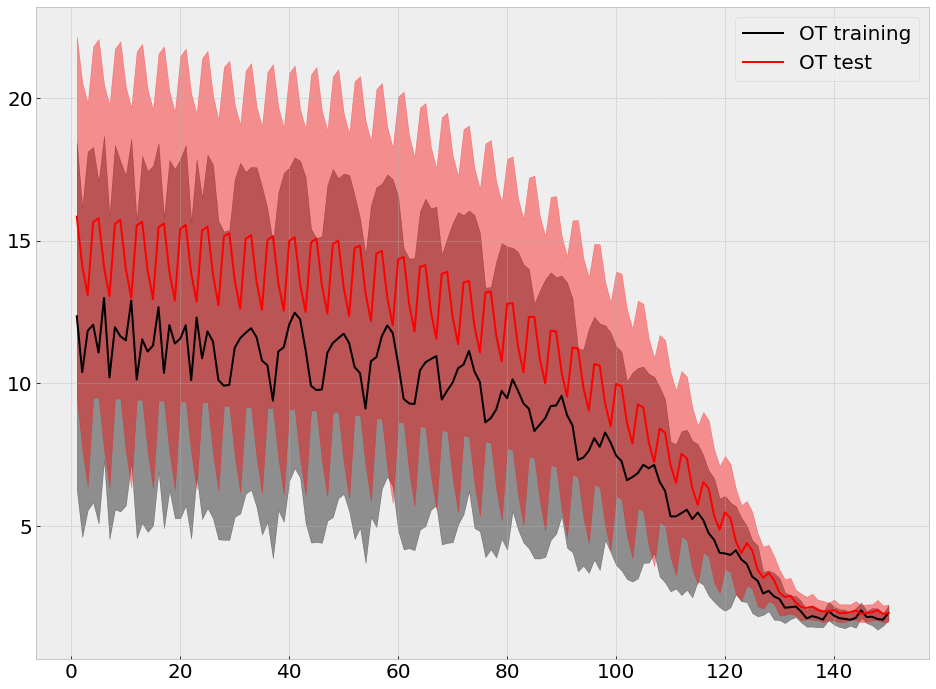

In [8]:
ys = np.array(trainerb.W1s)
upper = len(ys) #500
xs = np.linspace(1,upper,upper)
y2 = np.array(trainerb.W1test)


pl.figure(4)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
plt.plot(xs, ys[:,0], '-', color='black', label = 'OT training')
plt.fill_between(xs, ys[:,0] - ys[:,1], ys[:,0] + ys[:,1],
                 color='black', alpha=0.4)
plt.plot(xs, y2[:,0], '-', color='red', label = 'OT test')
plt.fill_between(xs, y2[:,0] - y2[:,1], y2[:,0] + y2[:,1],
                 color='red', alpha=0.4)
plt.legend(fontsize = 20)
#plt.ylim(-0.5,1.5)
plt.savefig('to10',dpi=150)

In [9]:
gens = np.concatenate((y_test,gen_ber(trainerb.model.G, y_test, num_z = 1)),axis = 1)
reals = np.concatenate((y_test,x_test[:,[0]]),axis = 1)
get_ot(gens,reals)

1.9640307921090114

In [10]:
gens_ber_means,gens_ber_std = np.zeros(num_test), np.zeros(num_test)

gens_ber = gen_ber(trainerb.model.G,y[test_idx:(test_idx+num_test),:])
for day_idx in range(num_test):
    gens_ber_means[day_idx], gens_ber_std[day_idx] = np.mean(gens_ber[day_idx,:]), np.std(gens_ber[day_idx,:])

np.mean(berlin_days), np.std(berlin_days), np.mean(gens_ber), np.std(gens_ber), np.mean(gens_ber[0,:]), np.std(gens_ber[0,:]) 

(13.468828451882846,
 7.651745985009357,
 13.425154460499195,
 7.382698191768507,
 14.562284565925598,
 0.043838127658705366)

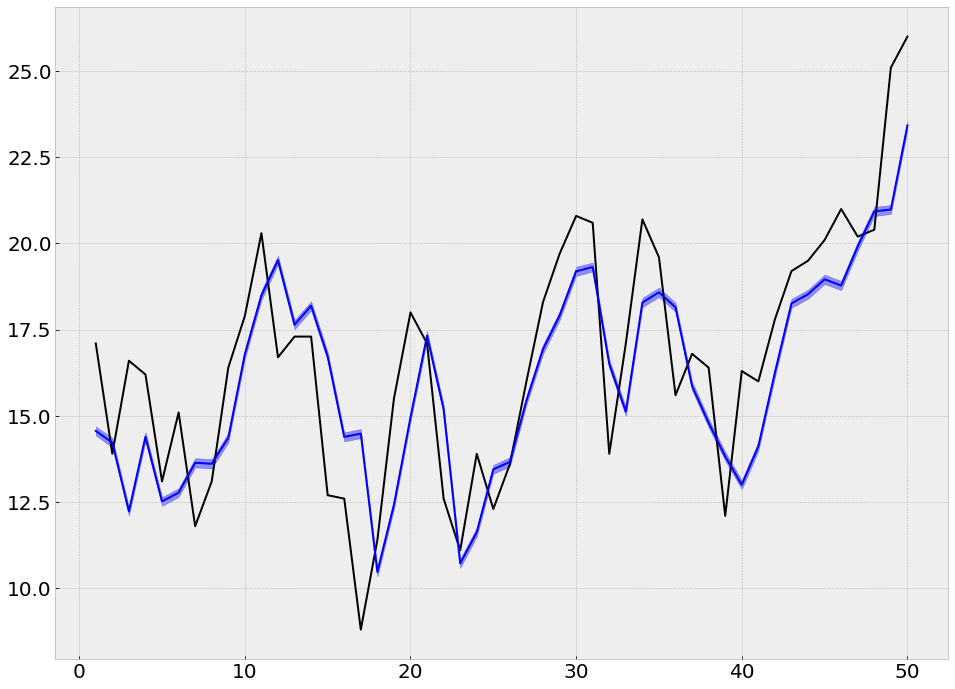

In [11]:
pl.figure(5)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
upper = 50 #len(berlin_days)
xs = np.linspace(1,upper,upper)
ys = berlin_days[:upper]
ygen = gens_ber_means[:upper]
stdgen = gens_ber_std[:upper]

plt.plot(xs, ys, '-', color='black', label = 'true')
plt.plot(xs, ygen, '-', color = 'blue', label = 'gen')
plt.fill_between(xs, ygen - 3*stdgen, ygen + 3*stdgen,
                 color='blue', alpha=0.4)

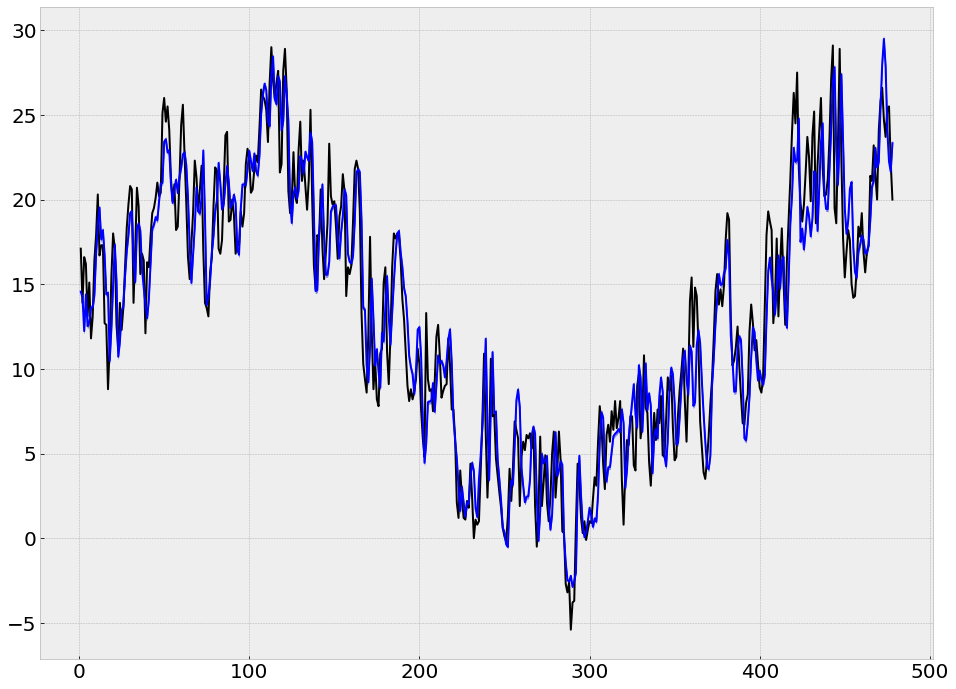

In [12]:
pl.figure(52)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
upper = len(berlin_days)
xs = np.linspace(1,upper,upper)
ys = berlin_days[:upper]
ygen = gens_ber_means[:upper]
stdgen = gens_ber_std[:upper]

plt.plot(xs, ys, '-', color='black', label = 'true')
plt.plot(xs, ygen, '-', color = 'blue', label = 'gen')
plt.fill_between(xs, ygen - 3*stdgen, ygen + 3*stdgen,
                 color='blue', alpha=0.4)

In [13]:
# take only one 
idx = 0

x_used = x[[idx]]
y_used = y[[idx]]
num_used = 1

gens_ber3 = gen_ber(trainerb.model.G, y_used)
for day_idx in range(y_used.shape[0]):
    gens_ber3_means, gens_ber3_std = np.mean(gens_ber3[0,:]), np.std(gens_ber3[0,:])

np.mean(x_used[:,0]), np.std(x_used[:,0]), np.mean(gens_ber3), np.std(gens_ber3)

(23.5, 0.0, 20.977772531509398, 0.044821122636723054)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


array([[22.2, 19.3, 19.9, 18.4, 21.4, 19.8, 19. , 22.3, 24.5, 16.4, 18.6,
        21.5, 19.6, 19.4, 21. , 17.4, 22.4, 21.5, 20. , 18.5, 19.9, 20.1,
        16.8, 18.5, 19.3, 19. , 17. , 19.3, 20.2, 20.6, 19.1, 22.6]])

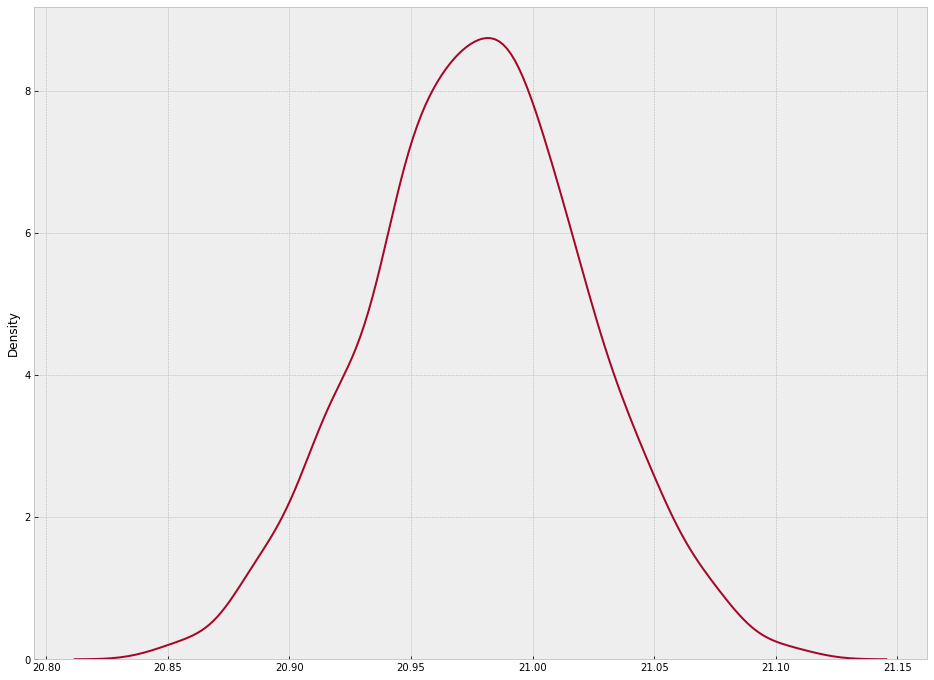

In [14]:
sns.kdeplot(x_used[:,0])
#sns.kdeplot(gens_ber2.flatten())
sns.kdeplot(gens_ber3.flatten())

y_used

In [15]:
num_z = 1000
alpha = 0.05

allgens = gen_ber(trainerb.model.G, y[:test_idx,:], num_z = num_z)
allgens = np.sort(allgens)
trainset_quantiles = allgens[:,[int(np.ceil(0.5*alpha*num_z)),int(np.ceil((1-0.5*alpha)*num_z))]]

sum([(trainset_quantiles[i,0] <= x[i,0]) and (x[i,0] <= trainset_quantiles[i,1]) for i in range(trainset_quantiles.shape[0])])/trainset_quantiles.shape[0]

0.029069767441860465

In [16]:
# 1-alpha empirical confidence intervall on test data
num_z = 10000
alpha = 0.05

allgens = gen_ber(trainerb.model.G, y_test, num_z = num_z)
allgens = np.sort(allgens)
test_quantiles2 = allgens[:,[int(np.ceil(0.5*alpha*num_z)),int(np.ceil((1-0.5*alpha)*num_z))]]

sum([(test_quantiles2[i,0] <= berlin_days[i]) and (berlin_days[i] <= test_quantiles2[i,1]) for i in range(test_quantiles2.shape[0])])/test_quantiles2.shape[0]

0.03138075313807531

# Same for 1000 epochs

In [17]:
random.seed(1056)
torch.manual_seed(1056)

trains, tests = get_cdataloader(x[:,[0]], y, tt_split = 0.8999, shuffle = False) #only ber [:,[0]]

#network architectures
#gdim=128
#ddim = 256
# input, 3 hidden layers, output layer
#network architectures
#gdim=32
#ddim = 64
#z_dim = 8
pg = (z_dim+y_dim, gdim, gdim, gdim, x_dim)
pd = (x_dim+y_dim, ddim,ddim,ddim,ddim, ddim, 1)

model = cWGAN(pg, pd)

trainer_long = cWGANTrainer(model=model, trains=trains, datas = data, testset=tests, gantype = 'wgangp')

# train D and G with estimates after each epoch, use num_batches for estimates
trainer_long.train_estim(num_epochs=1000, penalty = 0.1, G_lr=1e-4, D_lr=1e-4, G_wd = 0.01, D_wd = 0.01, D_steps_standard=5, num_batches = 1, num_estims = 10)

100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]


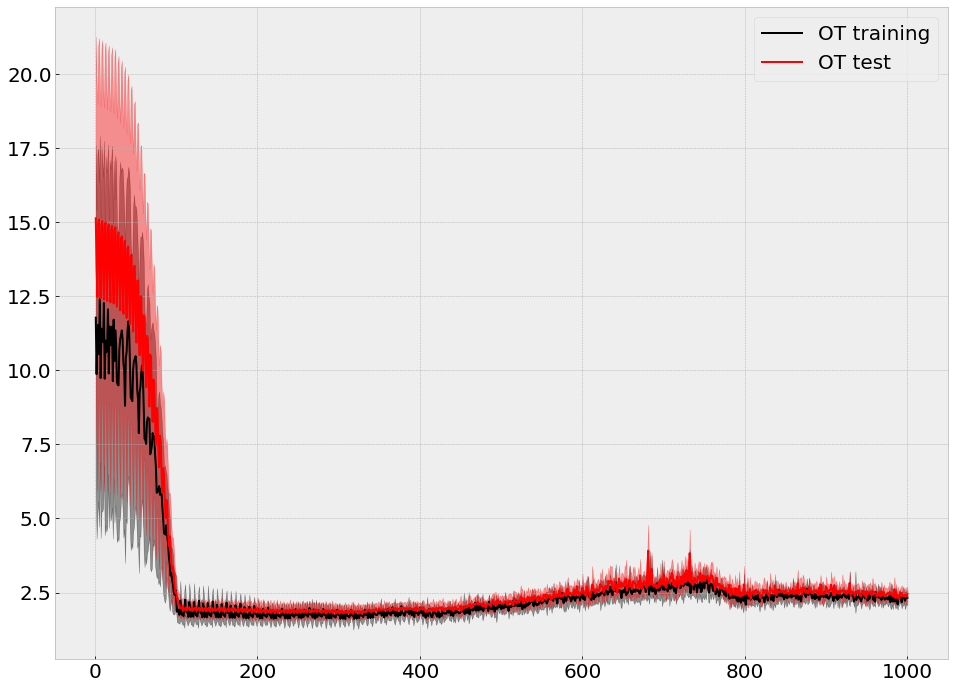

In [18]:
ys = np.array(trainer_long.W1s)
upper = len(ys) #500
xs = np.linspace(1,upper,upper)
y2 = np.array(trainer_long.W1test)


pl.figure(42)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
plt.plot(xs, ys[:,0], '-', color='black', label = 'OT training')
plt.fill_between(xs, ys[:,0] - ys[:,1], ys[:,0] + ys[:,1],
                 color='black', alpha=0.4)
plt.plot(xs, y2[:,0], '-', color='red', label = 'OT test')
plt.fill_between(xs, y2[:,0] - y2[:,1], y2[:,0] + y2[:,1],
                 color='red', alpha=0.4)
plt.legend(fontsize = 20)
#plt.ylim(-0.5,1.5)
plt.savefig('to10',dpi=150)

In [19]:
gens = np.concatenate((y_test,gen_ber(trainer_long.model.G, y_test, num_z = 1)),axis = 1)
reals = np.concatenate((y_test,x_test[:,[0]]),axis = 1)
get_ot(gens,reals)

2.383636450198487

In [20]:
gens_ber_means,gens_ber_std = np.zeros(num_test), np.zeros(num_test)

gens_ber = gen_ber(trainer_long.model.G,y[test_idx:(test_idx+num_test),:])
for day_idx in range(num_test):
    gens_ber_means[day_idx], gens_ber_std[day_idx] = np.mean(gens_ber[day_idx,:]), np.std(gens_ber[day_idx,:])

np.mean(berlin_days), np.std(berlin_days), np.mean(gens_ber), np.std(gens_ber), np.mean(gens_ber[0,:]), np.std(gens_ber[0,:]) 

(13.468828451882846,
 7.651745985009357,
 13.576535960098845,
 7.662287442157721,
 15.47907251548767,
 1.8396753551918357)

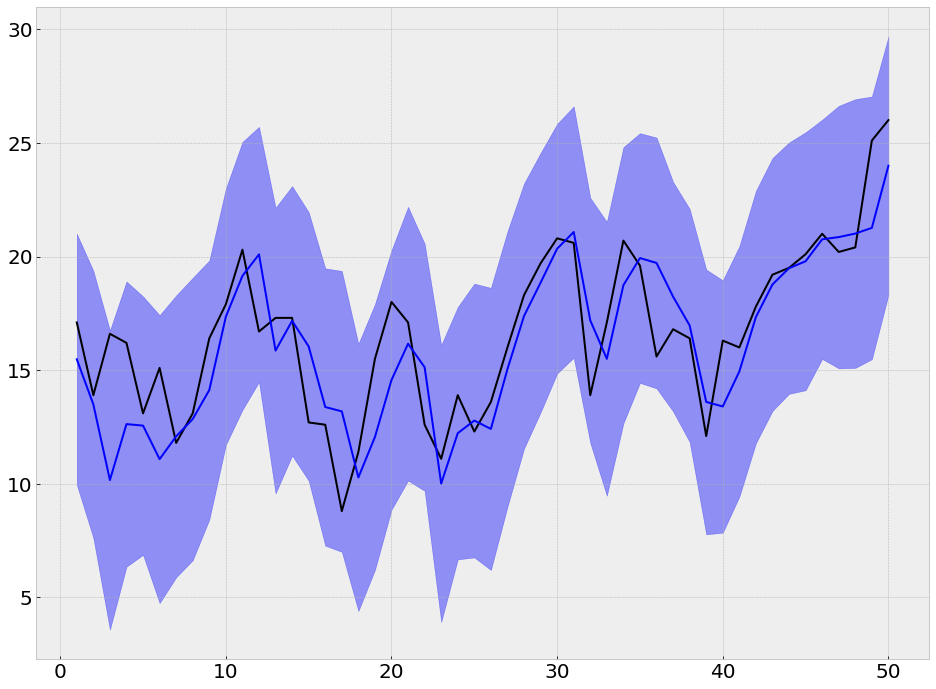

In [21]:
pl.figure(5)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
upper = 50 #len(berlin_days)
xs = np.linspace(1,upper,upper)
ys = berlin_days[:upper]
ygen = gens_ber_means[:upper]
stdgen = gens_ber_std[:upper]

plt.plot(xs, ys, '-', color='black', label = 'true')
plt.plot(xs, ygen, '-', color = 'blue', label = 'gen')
plt.fill_between(xs, ygen - 3*stdgen, ygen + 3*stdgen,
                 color='blue', alpha=0.4)

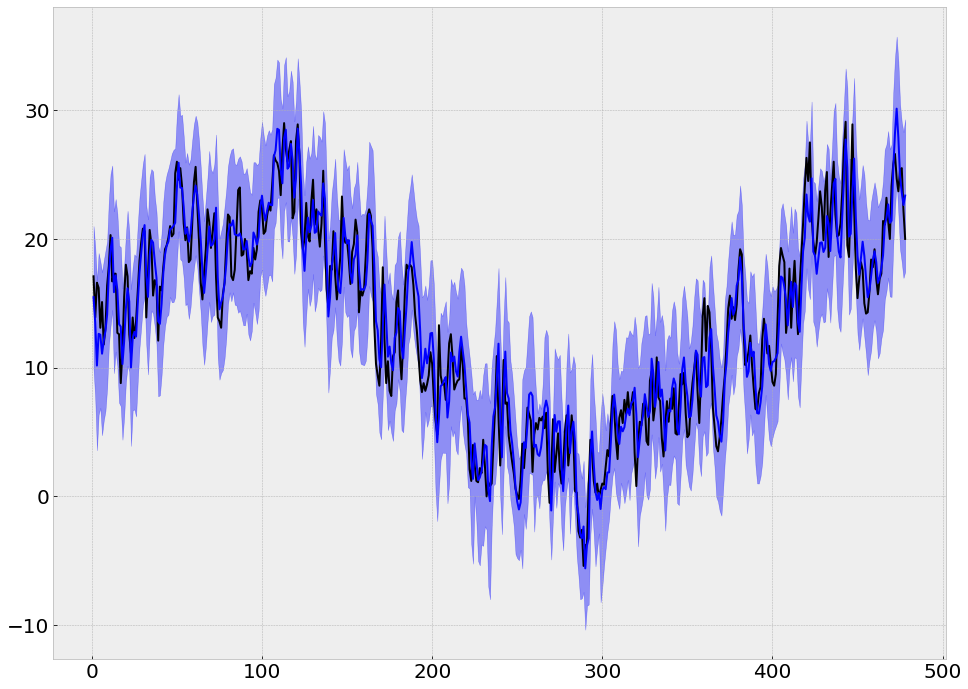

In [22]:
pl.figure(52)
plt.rcParams["figure.figsize"] = (8*2,6*2)
plt.style.use('bmh')
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
upper = len(berlin_days)
xs = np.linspace(1,upper,upper)
ys = berlin_days[:upper]
ygen = gens_ber_means[:upper]
stdgen = gens_ber_std[:upper]

plt.plot(xs, ys, '-', color='black', label = 'true')
plt.plot(xs, ygen, '-', color = 'blue', label = 'gen')
plt.fill_between(xs, ygen - 3*stdgen, ygen + 3*stdgen,
                 color='blue', alpha=0.4)

In [23]:
# take only one 
idx = 0

x_used = x[[idx]]
y_used = y[[idx]]
num_used = 1

gens_ber3 = gen_ber(trainer_long.model.G, y_used)
for day_idx in range(y_used.shape[0]):
    gens_ber3_means, gens_ber3_std = np.mean(gens_ber3[0,:]), np.std(gens_ber3[0,:])

np.mean(x_used[:,0]), np.std(x_used[:,0]), np.mean(gens_ber3), np.std(gens_ber3)

(23.5, 0.0, 21.730819752693176, 1.8994936978182138)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


array([[22.2, 19.3, 19.9, 18.4, 21.4, 19.8, 19. , 22.3, 24.5, 16.4, 18.6,
        21.5, 19.6, 19.4, 21. , 17.4, 22.4, 21.5, 20. , 18.5, 19.9, 20.1,
        16.8, 18.5, 19.3, 19. , 17. , 19.3, 20.2, 20.6, 19.1, 22.6]])

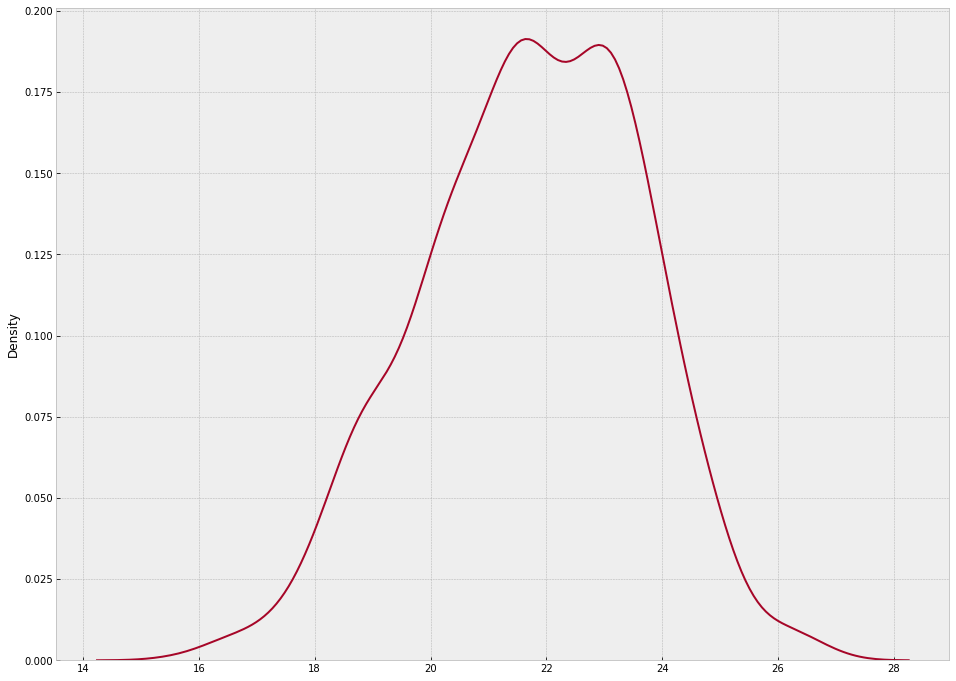

In [24]:
sns.kdeplot(x_used[:,0])
#sns.kdeplot(gens_ber2.flatten())
sns.kdeplot(gens_ber3.flatten())

y_used

In [25]:
num_z = 1000
alpha = 0.05

allgens = gen_ber(trainer_long.model.G, y[:test_idx,:], num_z = num_z)
allgens = np.sort(allgens)
trainset_quantiles = allgens[:,[int(np.ceil(0.5*alpha*num_z)),int(np.ceil((1-0.5*alpha)*num_z))]]

sum([(trainset_quantiles[i,0] <= x[i,0]) and (x[i,0] <= trainset_quantiles[i,1]) for i in range(trainset_quantiles.shape[0])])/trainset_quantiles.shape[0]

0.9113953488372093

In [26]:
# 1-alpha empirical confidence intervall on test data
num_z = 10000
alpha = 0.05

allgens = gen_ber(trainer_long.model.G, y_test, num_z = num_z)
allgens = np.sort(allgens)
test_quantiles2 = allgens[:,[int(np.ceil(0.5*alpha*num_z)),int(np.ceil((1-0.5*alpha)*num_z))]]

sum([(test_quantiles2[i,0] <= berlin_days[i]) and (berlin_days[i] <= test_quantiles2[i,1]) for i in range(test_quantiles2.shape[0])])/test_quantiles2.shape[0]

0.895397489539749